Projet 5 | Catégorisez automatiquement des questions

Partie 4.0 | Analyse Supervisée - encodage

# Présentation du projet
Nous cherchons a aider la communauté de Stack Overflow, site célèbre de questions-réponses liées au développement informatique, en réalisant un API de prédiction de tags.<br/>
L'analyse se basera sur le NLP (Natural language processing) et nous testerons différentes méthodes pour ne sélectionner que la plus efficace et pertinente.

# Import des packages, fonctions et paramétrage initial

Notebook variables reset for each complete execution of this code :

In [1]:
%reset -f

## Vérification de la version de Python

In [2]:
!python -V

Python 3.11.7


## Import des packages utiles au projet

### Libraries

In [3]:
# Modules classiques d'analyse exploratoire:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%pylab
%matplotlib inline

# Manipulation fichiers et Interaction avec l'os / notebook
import os
import csv
import requests
import warnings

# Libraries and packages for preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

Using matplotlib backend: <object object at 0x000001BC3C6B0E70>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### MLFlow
https://www.youtube.com/watch?v=6j_qhTJgB1w <br/>
https://medium.com/@shayan.nejadshamsi/how-to-install-and-set-up-mlflow-mlops-experiment-tracking-tool-d490f9427c58<br/>
http://127.0.0.1:5000

In [4]:
# check wether mlflow is installed
!mlflow --version

mlflow, version 2.12.1


C:\Users\A475388\AppData\Local\anaconda3\Lib\site-packages\pydantic\_internal\_config.py:334: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [5]:
import mlflow
from mlflow.tracking import MlflowClient
import mlflow.sklearn

In [6]:
#Pour chaque test :

#mlflow.set_experiment('IMLP5-Supervisé')
#mlflow.log_metric("score", score)
#mlflow.sklearn.log_model(lr, "model")

## Mise en page et réglages divers du notebook

In [7]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour bien visualiser les colonnes
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

# Affichage avec la bibliothèque graphique intégrée à Notebook:
%matplotlib inline

# Format des graphiques seaborn
sns.set_theme(style="whitegrid")

# Chargement et préparation des données

## Chargement des datasets

In [8]:
# Création des DataFrame
df_cleaned = pd.read_csv("C:/Users/A475388/Notebooks/IML P5/Data/df_cleaned.csv",
                 sep=';')
df_cleaned.head(1)

,Title,Body,Tags,lemmatized_corpus,lemmatized_tags,stemmed_corpus,stemmed_tags
0,Python kernel dies for second run of PyQt5 GUI,"<ul>\n<li>Using Spyder in Python 3.5.2 |Anaconda 4.2.0 (64-bit) Windows package. qt: 5.6.0</li>\n<li>For first run, GUI window opens as expected</li>\n<li>For 2nd run, nothing opens, and receiving <strong>Kernel died, restarting</strong> log message.</li>\n</ul>\n\n<p><strong>gui1.py:</strong></p>\n\n<blockquote>\n<pre><code>import sys from PyQt5.QtWidgets import QApplication, QWidget\n\napp = QApplication(sys.argv)\n\nw = QWidget()\n\nw.resize(250,150) w.show()\n\n#sys.exit(app.exec_()) \napp.exec_()\n</code></pre>\n</blockquote>\n\n<p><strong>IPhython log:</strong></p>\n\n<pre><code>runfile('F:/work/ws_python/TestProj1/gui1/gui1.py', wdir='F:/work/ws_python/TestProj1/gui1')\n\nrunfile('F:/work/ws_python/TestProj1/gui1/gui1.py', wdir='F:/work/ws_python/TestProj1/gui1')\n\nKernel died, restarting\n\nKernel died, restarting\n\nKernel died, restarting\n</code></pre>\n\n<p>Why kernel dies for 2nd run and how to solve it?</p>\n\n<blockquote>\n <p>(Doing the same even using #sys.exit(app.exec_()) as last line.)</p>\n</blockquote>\n",<python><ipython><anaconda><pyqt5><spyder>,"['python', 'kernel', 'dy', 'second', 'pyqt', 'using', 'spyder', 'python', 'anaconda', 'window', 'package', 'first', 'window', 'open', 'expected', 'nothing', 'open', 'receiving', 'kernel', 'died', 'restarting', 'message', 'import', 'pyqt', 'qtwidgets', 'import', 'qapplication', 'qwidget', 'qapplication', 'argv', 'qwidget', 'resize', 'show', 'exit', 'exec', 'exec', 'iphython', 'runfile', 'work', 'python', 'testproj', 'wdir', 'work', 'python', 'testproj', 'runfile', 'work', 'python', 'testproj', 'wdir', 'work', 'python', 'testproj', 'kernel', 'died', 'restarting', 'kernel', 'died', 'restarting', 'kernel', 'died', 'restarting', 'kernel', 'dy', 'solve', 'even', 'using', 'exit', 'exec', 'last', 'line']","['python', 'ipython', 'anaconda', 'pyqt', 'spyder']","['python', 'kernel', 'die', 'second', 'pyqt', 'use', 'spyder', 'python', 'anaconda', 'window', 'packag', 'first', 'window', 'open', 'expect', 'noth', 'open', 'receiv', 'kernel', 'die', 'restart', 'messag', 'import', 'pyqt', 'qtwidget', 'import', 'qapplic', 'qwidget', 'qapplic', 'argv', 'qwidget', 'resiz', 'show', 'exit', 'exec', 'exec', 'iphython', 'runfil', 'work', 'python', 'testproj', 'wdir', 'work', 'python', 'testproj', 'runfil', 'work', 'python', 'testproj', 'wdir', 'work', 'python', 'testproj', 'kernel', 'die', 'restart', 'kernel', 'die', 'restart', 'kernel', 'die', 'restart', 'kernel', 'die', 'solv', 'even', 'use', 'exit', 'exec', 'last', 'line']","['python', 'ipython', 'anaconda', 'pyqt', 'spyder']"


In [9]:
import ast
df_cleaned['lemmatized_corpus'] = df_cleaned['lemmatized_corpus'].map(
    lambda x: ast.literal_eval(x)
)
df_cleaned['lemmatized_tags'] = df_cleaned['lemmatized_tags'].map(
    lambda x: ast.literal_eval(x)
)
df_cleaned['stemmed_corpus'] = df_cleaned['stemmed_corpus'].map(
    lambda x: ast.literal_eval(x)
)
df_cleaned['stemmed_tags'] = df_cleaned['stemmed_tags'].map(
    lambda x: ast.literal_eval(x)
)

In [10]:
df = df_cleaned.copy()

# Preprocessing

In [11]:
from nltk import FreqDist

In [12]:
%%time
def build_word_distribution(corpus):
    """
    Build corpus word distribution

    Args:
        Corpus(List of lists): Original corpus

    Returns:

        word_dist_df(DataFrame): Word distribution of the corpus
    """
    word_corpus = [token for token_list in corpus for token in token_list]
    word_dist = FreqDist(word_corpus)
    word_dist_df = pd.DataFrame(word_dist.items(), columns=['Word', 'Frequency']).set_index('Word')
    word_dist_df.sort_values("Frequency", ascending=False, inplace=True)

    return word_dist_df

CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
corpus = df['lemmatized_corpus'].to_list()
word_dist = build_word_distribution(corpus)

tags = df['lemmatized_tags'].to_list()
tag_dist = build_word_distribution(tags)

In [14]:
vocabulary = list(word_dist[word_dist["Frequency"]>=1000].index)
len(vocabulary)

630

In [15]:
corpus = df['lemmatized_corpus'].apply(lambda x: ' '.join(x))

## Bag of words
CountVectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [17]:
vectorizer = CountVectorizer(vocabulary=vocabulary)
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['java', 'error', 'file', 'android', 'class', 'using', 'name',
       'http', 'user', 'data', 'import', 'code', 'test', 'return',
       'public', 'string', 'version', 'module', 'function', 'value',
       'type', 'like', 'python', 'build', 'work', 'true', 'project',
       'server', 'method', 'package', 'request', 'want', 'node', 'json',
       'application', 'self', 'object', 'springframework', 'line', 'core',
       'service', 'model', 'image', 'following', 'spring', 'tried',
       'path', 'would', 'text', 'react', 'trying', 'view', 'dependency',
       'time', 'example', 'need', 'problem', 'create', 'apache', 'main',
       'html', 'gradle', 'found', 'component', 'client', 'system',
       'result', 'internal', 'message', 'content', 'private', 'also',
       'option', 'script', 'null', 'item', 'find', 'false', 'support',
       'library', 'default', 'response', 'google', 'context', 'call',
       'list', 'info', 'install', 'array', 'window', 'layout', 'make',
       'command

In [18]:
bag_of_words_data = pd.DataFrame(X.toarray(), columns=vocabulary)
print("Affichage des 10 premiers posts vectorisés via le modèle de Bag of words")
display(bag_of_words_data.sample(10))
print(f" Nombre d'observations: {bag_of_words_data.shape[0]}, nombre de variables: {bag_of_words_data.shape[1]}")

Affichage des 10 premiers posts vectorisés via le modèle de Bag of words


,java,error,file,android,class,using,name,http,user,data,import,code,test,return,public,string,version,module,function,value,type,like,python,build,work,true,project,server,method,package,request,want,node,json,application,self,object,springframework,line,core,service,model,image,following,spring,tried,path,would,text,react,trying,view,dependency,time,example,need,problem,create,apache,main,html,gradle,found,component,client,system,result,internal,message,content,private,also,option,script,null,item,find,false,support,library,default,response,google,context,call,list,info,install,array,window,layout,make,command,input,local,void,know,index,config,exception,...,latest,center,valid,category,kera,generate,anaconda,someone,logger,word,expect,actually,exit,play,approach,worker,credential,jackson,active,section,cell,disable,loading,protected,meta,material,insert,random,alert,around,log,successfully,row,related,origin,external,made,plot,undefined,place,pool,append,runner,dataset,webdriver,requirement,total,shared,endpoint,sort,float,caused,bind,design,replace,tutorial,rule,card,nested,flask,going,fails,starter,say,come,head,language,asset,dynamic,padding,rail,azure,enabled,bottom,copying,changed,binary,backend,timeout,concurrent,pattern,manager,accept,appdata,dispatch,achieve,normal,conf,exists,println,desktop,exist,complete,startup,person,eslint,installing,apps,might,theme
19863,1,1,0,0,1,0,0,0,0,0,0,3,0,2,3,2,0,0,0,2,3,0,0,2,0,0,0,0,1,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,3,0,0,0,0,3,1,1,0,0,2,0,0,0,0,0,0,10,0,0,7,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10132,0,0,0,0,0,2,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,9,0,2,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
9168,0,0,1,0,0,0,1,0,0,0,0,0,6,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15821,0,0,0,0,0,2,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11105,3,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23824,0,1,0,0,0,3,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
450,0,1,0,0,0,0,2,0,0,0,0,1,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,2,0,0,0,0,0,0,0,

 Nombre d'observations: 29995, nombre de variables: 630


In [19]:
bag_of_words_data.describe()

,java,error,file,android,class,using,name,http,user,data,import,code,test,return,public,string,version,module,function,value,type,like,python,build,work,true,project,server,method,package,request,want,node,json,application,self,object,springframework,line,core,service,model,image,following,spring,tried,path,would,text,react,trying,view,dependency,time,example,need,problem,create,apache,main,html,gradle,found,component,client,system,result,internal,message,content,private,also,option,script,null,item,find,false,support,library,default,response,google,context,call,list,info,install,array,window,layout,make,command,input,local,void,know,index,config,exception,...,latest,center,valid,category,kera,generate,anaconda,someone,logger,word,expect,actually,exit,play,approach,worker,credential,jackson,active,section,cell,disable,loading,protected,meta,material,insert,random,alert,around,log,successfully,row,related,origin,external,made,plot,undefined,place,pool,append,runner,dataset,webdriver,requirement,total,shared,endpoint,sort,float,caused,bind,design,replace,tutorial,rule,card,nested,flask,going,fails,starter,say,come,head,language,asset,dynamic,padding,rail,azure,enabled,bottom,copying,changed,binary,backend,timeout,concurrent,pattern,manager,accept,appdata,dispatch,achieve,normal,conf,exists,println,desktop,exist,complete,startup,person,eslint,installing,apps,might,theme
count,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.00000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,...,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000
m

## TF-IDF

### Vectorisation

In [20]:
%%time
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary)
X = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

CPU times: total: 2.22 s
Wall time: 2.21 s


In [21]:
tfidf_data = pd.DataFrame(X.toarray(), columns=vocabulary)
print("Affichage des 10 premiers posts vectorisés via le modèle de TF-IDF")
display(tfidf_data.sample(10))
print(f" Nombre d'observations: {tfidf_data.shape[0]}, nombre de variables: {tfidf_data.shape[1]}")

Affichage des 10 premiers posts vectorisés via le modèle de TF-IDF


,java,error,file,android,class,using,name,http,user,data,import,code,test,return,public,string,version,module,function,value,type,like,python,build,work,true,project,server,method,package,request,want,node,json,application,self,object,springframework,line,core,service,model,image,following,spring,tried,path,would,text,react,trying,view,dependency,time,example,need,problem,create,apache,main,html,gradle,found,component,client,system,result,internal,message,content,private,also,option,script,null,item,find,false,support,library,default,response,google,context,call,list,info,install,array,window,layout,make,command,input,local,void,know,index,config,exception,...,latest,center,valid,category,kera,generate,anaconda,someone,logger,word,expect,actually,exit,play,approach,worker,credential,jackson,active,section,cell,disable,loading,protected,meta,material,insert,random,alert,around,log,successfully,row,related,origin,external,made,plot,undefined,place,pool,append,runner,dataset,webdriver,requirement,total,shared,endpoint,sort,float,caused,bind,design,replace,tutorial,rule,card,nested,flask,going,fails,starter,say,come,head,language,asset,dynamic,padding,rail,azure,enabled,bottom,copying,changed,binary,backend,timeout,concurrent,pattern,manager,accept,appdata,dispatch,achieve,normal,conf,exists,println,desktop,exist,complete,startup,person,eslint,installing,apps,might,theme
16152,0.0,0.000000,0.000000,0.0,0.000000,0.169098,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152259,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.114108,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.119654,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.574483,0.0,0.128573,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.279344,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.271304,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.214094,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
20750,0.0,0.000000,0.140849,0.0,0.000000,0.000000,0.142964,0.0,0.011836,0.000000,0.050370,0.009059,0.037899,0.021473,0.000000,0.036238,0.000000,0.000000,0.011877,0.251712,0.011811,0.000000,0.013906,0.000000,0.000000,0.147288,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.013816,0.0,0.014584,0.000000,0.0,0.021856,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.013117,0.0,0.000000,0.011859,0.050956,0.019107,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.093846,0.014400,0.0,0.0,0.012036,0.059246,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.013863,0.0,0.0,0.0,0.0,0.014971,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.031827,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.085187,0.000000,0.0,0.063784,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.022002,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.112057,0.0,0.0,0.0,0.062694,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234255,0.021062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043133,0.0,0.0
1103,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,

 Nombre d'observations: 29995, nombre de variables: 630


In [22]:
tfidf_data.describe()

,java,error,file,android,class,using,name,http,user,data,import,code,test,return,public,string,version,module,function,value,type,like,python,build,work,true,project,server,method,package,request,want,node,json,application,self,object,springframework,line,core,service,model,image,following,spring,tried,path,would,text,react,trying,view,dependency,time,example,need,problem,create,apache,main,html,gradle,found,component,client,system,result,internal,message,content,private,also,option,script,null,item,find,false,support,library,default,response,google,context,call,list,info,install,array,window,layout,make,command,input,local,void,know,index,config,exception,...,latest,center,valid,category,kera,generate,anaconda,someone,logger,word,expect,actually,exit,play,approach,worker,credential,jackson,active,section,cell,disable,loading,protected,meta,material,insert,random,alert,around,log,successfully,row,related,origin,external,made,plot,undefined,place,pool,append,runner,dataset,webdriver,requirement,total,shared,endpoint,sort,float,caused,bind,design,replace,tutorial,rule,card,nested,flask,going,fails,starter,say,come,head,language,asset,dynamic,padding,rail,azure,enabled,bottom,copying,changed,binary,backend,timeout,concurrent,pattern,manager,accept,appdata,dispatch,achieve,normal,conf,exists,println,desktop,exist,complete,startup,person,eslint,installing,apps,might,theme
count,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,...,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000,29995.000000


In [23]:
df_tfidf = pd.concat([df, tfidf_data], axis = 1)

In [24]:
df_tfidf.shape

(29995, 637)

In [25]:
df_tfidf = df_tfidf.dropna(subset=['Title'])

In [26]:
df_tfidf.shape

(29995, 637)

In [27]:
df_tfidf.head()

Title  \
0                          Python kernel dies for second run of PyQt5 GUI   
1              How can I use optional chaining with arrays and functions?   
2  When to apply(pd.to_numeric) and when to astype(np.float64) in python?   
3                                         Get Webpack not to bundle files   
4                                                SwiftUI tappable subtext   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

### TSNE

In [28]:
# Création des DataFrame
df_tsne_tfidf = pd.read_csv("C:/Users/A475388/Notebooks/IML P5/Data/df_tsne_tfidf.csv",
                            sep=';')
df_tsne_tfidf.head(1)

,Dim0,Dim1
0,19.293026,36.520027


<Axes: xlabel='Dim0', ylabel='Dim1'>

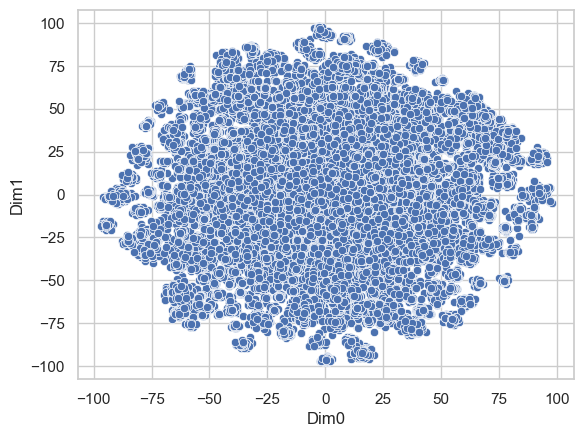

In [29]:
sns.scatterplot(data=df_tsne_tfidf,
                x="Dim0",
                y="Dim1",
                )

In [30]:
df_tot_tfidf = pd.read_csv("C:/Users/A475388/Notebooks/IML P5/Data/df_tot_tfidf.csv",
                            sep=';')
df_tot_tfidf.head(1)

,Title,Body,Tags,CreationDate,AnswerCount,ViewCount,Score,Date,CreationDateTimeDelta,Text_complet,Text_cleaned,Tags_cleaned,Title_cleaned,tokenized_corpus,tokenized_tags,lemmatized_corpus,lemmatized_tags,stemmed_corpus,stemmed_tags,java,error,file,using,class,android,name,http,user,data,code,return,test,public,import,string,version,like,type,value,function,module,python,build,work,project,true,server,method,want,package,request,application,self,object,line,node,following,json,image,would,model,service,core,springframework,tried,text,path,time,trying,example,view,need,spring,system,problem,create,main,react,dependency,found,result,also,client,html,apache,message,find,content,private,null,component,default,option,script,gradle,library,call,false,item,make,...,accept,comment,though,bash,apps,dispatch,nested,concurrent,worked,master,card,register,webdriver,constraint,desktop,cookie,advance,define,flask,startup,get,spec,theme,copying,thank,global,properly,queue,namespace,azure,identity,stop,report,starter,virtual,println,scroll,manually,article,built,sudo,margin,failure,rail,eslint,transform,binding,automatically,transaction,secret,named,appdata,key,suggestion,attempt,deploy,calling,curl,double,starting,break,mingw,temp,authorization,beta,primary,production,vendor,maybe,year,performance,dofilter,medium,specified,tostring,space,timestamp,unique,never,follows,impl,foreach,directly,refresh,mongodb,future,several,writing,switch,weight,facebook,redirect,utils,protocol,char,submit,run,recent,Dim0,Dim1
0,Python kernel dies for second run of PyQt5 GUI,"<ul>\n<li>Using Spyder in Python 3.5.2 |Anaconda 4.2.0 (64-bit) Windows package. qt: 5.6.0</li>\n<li>For first run, GUI window opens as expected</li>\n<li>For 2nd run, nothing opens, and receiving <strong>Kernel died, restarting</strong> log message.</li>\n</ul>\n\n<p><strong>gui1.py:</strong></p>\n\n<blockquote>\n<pre><code>import sys from PyQt5.QtWidgets import QApplication, QWidget\n\napp = QApplication(sys.argv)\n\nw = QWidget()\n\nw.resize(250,150) w.show()\n\n#sys.exit(app.exec_()) \napp.exec_()\n</code></pre>\n</blockquote>\n\n<p><strong>IPhython log:</strong></p>\n\n<pre><code>runfile('F:/work/ws_python/TestProj1/gui1/gui1.py', wdir='F:/work/ws_python/TestProj1/gui1')\n\nrunfile('F:/work/ws_python/TestProj1/gui1/gui1.py', wdir='F:/work/ws_python/TestProj1/gui1')\n\nKernel died, restarting\n\nKernel died, restarting\n\nKernel died, restarting\n</code></pre>\n\n<p>Why kernel dies for 2nd run and how to solve it?</p>\n\n<blockquote>\n <p>(Doing the same even using #sys.exit(app.exec_()) as last line.)</p>\n</blockquote>\n",<python><ipython><anaconda><pyqt5><spyder>,2016-10-17 19:21:55,3.0,10077.0,17.0,2016-10-17 19:21:55,2591.0,"Python kernel dies for second run of PyQt5 GUI<ul>\n<li>Using Spyder in Python 3.5.2 |Anaconda 4.2.0 (64-bit) Windows package. qt: 5.6.0</li>\n<li>For first run, GUI window opens as expected</li>\n<li>For 2nd run, nothing opens, and receiving <strong>Kernel died, restarting</strong> log message.</li>\n</ul>\n\n<p><strong>gui1.py:</strong></p>\n\n<blockquote>\n<pre><code>import sys from PyQt5.QtWidgets import QApplication, QWidget\n\napp = QApplication(sys.argv)\n\nw = QWidget()\n\nw.resize(250,150) w.show()\n\n#sys.exit(app.exec_()) \napp.exec_()\n</code></pre>\n</blockquote>\n\n<p><strong>IPhython log:</strong></p>\n\n<pre><code>runfile('F:/work/ws_python/TestProj1/gui1/gui1.py', wdir='F:/work/ws_python/TestProj1/gui1')\n\nrunfile('F:/work/ws_python/TestProj1/gui1/gui1.py', wdir='F:/work/ws_python/TestProj1/gui1')\n\nKernel died, restarting\n\nKernel died, restarting\n\nKernel died, restarting\n</code></pre>\n\n<p>Why kernel dies for 2nd run and how to solve it?</p>\n\n<blockquote>\n <p>(Doing the same even using #sys.exit(app.exec_()) as last line.)</p>\n</blockquote>\n",python kernel dies second pyqt using spyder python anaconda windows package first window opens expected nothing opens receiving kernel died restarting message import from pyqt qtwidgets import

# Approche supervisée

In [31]:
col_to_drop = []
X = tfidf_data.copy().drop(columns = col_to_drop)
y = df['stemmed_tags']

## Split dataset

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [33]:
nb_dim = tfidf_data.shape[1]
print(f"Le passage au Tf-Idf a généré {nb_dim} dimensions, il nous faut les réduire.")

Le passage au Tf-Idf a généré 630 dimensions, il nous faut les réduire.


## Réduction de dimension - ACP

In [34]:
from sklearn.preprocessing import StandardScaler
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

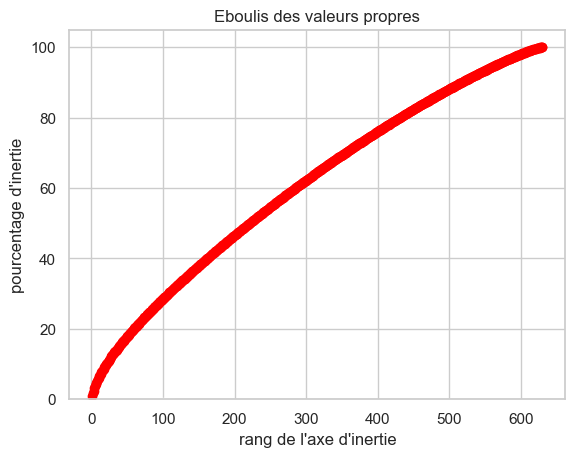

In [35]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

display_scree_plot(pca)

In [36]:
var = 0.60

pca = PCA(n_components=var, random_state=42)
pca.fit(X_train_scaled)
X_train_transformed = pca.transform(X_train_scaled)
X_test_transformed = pca.transform(X_test_scaled)
print(f"Nombre de composantes principales avec {var*100}% de la variance expliquée : {pca.components_.shape[0]}")
print(f"Nous avons gardé {round((pca.components_.shape[0]/nb_dim)*100,0)}% des dimensions")

Nombre de composantes principales avec 60.0% de la variance expliquée : 286
Nous avons gardé 45.0% des dimensions


## Vectorisation des tags

In [37]:
tag_dist = pd.read_csv("C:/Users/A475388/Notebooks/IML P5/Data/tag_dist.csv",
                 sep=';')
tag_dist

,Word,Frequency
0,python,7927
1,android,7149
2,java,5038
3,javascript,4809
4,spring,4119
...,...,...
7568,mnesia,1
7569,jetson,1
7570,sendmessage,1
7571,tiff,1


In [38]:
tag_dist = tag_dist.set_index('Word')
tag_dist

,Frequency
Word,
python,7927
android,7149
java,5038
javascript,4809
spring,4119
...,...
mnesia,1
jetson,1
sendmessage,1


In [39]:
m = 50
first_m_tags = tag_dist[1:m].index.to_list()

In [40]:
first_m_tags

['android',
 'java',
 'javascript',
 'spring',
 'node',
 'core',
 'angular',
 'google',
 'swift',
 'studio',
 'html',
 'reactjs',
 'amazon',
 'xcode',
 'laravel',
 'testing',
 'react',
 'json',
 'django',
 'typescript',
 'docker',
 'visual',
 'apache',
 'boot',
 'panda',
 'service',
 'gradle',
 'linux',
 'window',
 'framework',
 'jquery',
 'data',
 'firebase',
 'http',
 'azure',
 'spark',
 'server',
 'learning',
 'selenium',
 'flutter',
 'ruby',
 'unit',
 'bootstrap',
 'angularjs',
 'rest',
 'array',
 'database',
 'cloud',
 'dataframe']

In [41]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=first_m_tags)
train_labels = mlb.fit_transform(y_train)
test_labels = mlb.transform(y_test)

print("Affichage des classes du modèle de vectorisation :")
print("-"*60)
display(mlb.classes_)

Affichage des classes du modèle de vectorisation :
------------------------------------------------------------


array(['android', 'java', 'javascript', 'spring', 'node', 'core',
       'angular', 'google', 'swift', 'studio', 'html', 'reactjs',
       'amazon', 'xcode', 'laravel', 'testing', 'react', 'json', 'django',
       'typescript', 'docker', 'visual', 'apache', 'boot', 'panda',
       'service', 'gradle', 'linux', 'window', 'framework', 'jquery',
       'data', 'firebase', 'http', 'azure', 'spark', 'server', 'learning',
       'selenium', 'flutter', 'ruby', 'unit', 'bootstrap', 'angularjs',
       'rest', 'array', 'database', 'cloud', 'dataframe'], dtype=object)

## Modélisations - ML

### Evaluation des modèles

In [42]:
# Algo supervisés
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss, jaccard_score

In [43]:
models_performance = {}

def metrics_report(model_name, test_labels, predictions, performances):
    """
    Compute performance metrics of a model and store them in a dictionary

    Args:
        model_name(string): name of the evaluated model
        test_labels(array): labels related to predictors
        preductions(array): predicted results
        performances(dict): used dictionary to store metrics
    Returns:
        performances(dict): used dictionary to store metrics filed with models ones
    """
    accuracy = accuracy_score(test_labels, predictions)
    jaccard = jaccard_score(test_labels, predictions, average='macro')
    hamLoss = hamming_loss(test_labels, predictions)

    weighted_precision = precision_score(test_labels, predictions, average='weighted')
    weighted_recall = recall_score(test_labels, predictions, average='weighted')
    weighted_f1 = f1_score(test_labels, predictions, average='weighted')

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')


    with mlflow.start_run():

      print("------" + model_name + " Model Metrics-----")
    #print("Balanced Accuracy: {:.4f}\nAccuracy: {:.4f}\nJaccard: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
    #      .format(balanced_accuracy, accuracy, jaccard, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))

      performances[model_name] = {}
      performances[model_name]["Accuracy"] =  round(accuracy,2)
      performances[model_name]["Precision"] =  round(weighted_precision,2)
      performances[model_name]["Recall"] = round(weighted_recall,2)
      performances[model_name]["F1"] = round(weighted_f1,2)
      performances[model_name]["Haming loss"] = round(hamLoss,2)
      performances[model_name]["Jaccard score"] = round(jaccard,2)

      mlflow.log_metric("Accuracy", round(accuracy,2))
      mlflow.log_param(model_name, "model")

      return performances

### KNN

In [44]:
%%time
knn_clf = OneVsRestClassifier(KNeighborsClassifier(), n_jobs=-1)
knn_clf.fit(X_train_transformed, train_labels)
knn_predictions = knn_clf.predict(X_test_transformed)
metrics_report("knn", test_labels, knn_predictions, models_performance)

------knn Model Metrics-----
CPU times: total: 5min 22s
Wall time: 42.6 s


{'knn': {'Accuracy': 0.31,
  'Precision': 0.7,
  'Recall': 0.34,
  'F1': 0.45,
  'Haming loss': 0.02,
  'Jaccard score': 0.21}}

### SVM

In [45]:
%%time
svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svm_clf.fit(X_train_transformed, train_labels)

svm_preds = svm_clf.predict(X_test_transformed)
metrics_report("svm", test_labels, svm_preds, models_performance)

------svm Model Metrics-----
CPU times: total: 562 ms
Wall time: 1min 7s


{'knn': {'Accuracy': 0.31,
  'Precision': 0.7,
  'Recall': 0.34,
  'F1': 0.45,
  'Haming loss': 0.02,
  'Jaccard score': 0.21},
 'svm': {'Accuracy': 0.4,
  'Precision': 0.79,
  'Recall': 0.49,
  'F1': 0.59,
  'Haming loss': 0.02,
  'Jaccard score': 0.31}}

### Random Forest

In [46]:
%%time
rf_clf = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)
rf_clf.fit(X_train_transformed, train_labels)
rf_preds = rf_clf.predict(X_test_transformed)
metrics_report("Random Forest", test_labels, rf_preds, models_performance)

------Random Forest Model Metrics-----
CPU times: total: 5.3 s
Wall time: 6min 14s


{'knn': {'Accuracy': 0.31,
  'Precision': 0.7,
  'Recall': 0.34,
  'F1': 0.45,
  'Haming loss': 0.02,
  'Jaccard score': 0.21},
 'svm': {'Accuracy': 0.4,
  'Precision': 0.79,
  'Recall': 0.49,
  'F1': 0.59,
  'Haming loss': 0.02,
  'Jaccard score': 0.31},
 'Random Forest': {'Accuracy': 0.26,
  'Precision': 0.86,
  'Recall': 0.19,
  'F1': 0.29,
  'Haming loss': 0.02,
  'Jaccard score': 0.12}}

### Gradient boosting

In [47]:
%%time
gb_clf = OneVsRestClassifier(GradientBoostingClassifier(), n_jobs=-1)
gb_clf.fit(X_train_transformed, train_labels)
gb_preds = gb_clf.predict(X_test_transformed)
metrics_report("Gradient Boosting", test_labels, gb_preds, models_performance)

------Gradient Boosting Model Metrics-----
CPU times: total: 1.27 s
Wall time: 25min 4s


{'knn': {'Accuracy': 0.31,
  'Precision': 0.7,
  'Recall': 0.34,
  'F1': 0.45,
  'Haming loss': 0.02,
  'Jaccard score': 0.21},
 'svm': {'Accuracy': 0.4,
  'Precision': 0.79,
  'Recall': 0.49,
  'F1': 0.59,
  'Haming loss': 0.02,
  'Jaccard score': 0.31},
 'Random Forest': {'Accuracy': 0.26,
  'Precision': 0.86,
  'Recall': 0.19,
  'F1': 0.29,
  'Haming loss': 0.02,
  'Jaccard score': 0.12},
 'Gradient Boosting': {'Accuracy': 0.33,
  'Precision': 0.72,
  'Recall': 0.4,
  'F1': 0.5,
  'Haming loss': 0.02,
  'Jaccard score': 0.23}}

### Résultats

In [48]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

,Accuracy,Precision,Recall,F1,Haming loss,Jaccard score
knn,0.31,0.70,0.34,0.45,0.02,0.21
svm,0.40,0.79,0.49,0.59,0.02,0.31
Random Forest,0.26,0.86,0.19,0.29,0.02,0.12
Gradient Boosting,0.33,0.72,0.40,0.50,0.02,0.23


In [50]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
     #lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_textdf_stack

In [ ]:
df['Text_complet'] = df['Title'] + df['Body']
df['sentence_bow'] = df['Text_complet'].apply(lambda x : transform_bow_fct(x))
df['sentence_bow_lem'] = df['Text_complet'].apply(lambda x : transform_bow_lem_fct(x))

In [ ]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])
ctf_transform = ctf.transform(df[feat])

In [ ]:
from sklearn.model_selection import train_test_split
X = df['sentence_bow_lem']
#y = df['Tags']
y = df['lemmatized_tags']
text_train, text_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

In [ ]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = text_train.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
# Création et entraînement du modèle Word2Vec
%time
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

In [ ]:
def w2v_model_accuracy(model):

    accuracy = model.wv.accuracy(questions)
    
    sum_corr = len(accuracy[-1]['correct'])
    sum_incorr = len(accuracy[-1]['incorrect'])
    total = sum_corr + sum_incorr
    percent = lambda a: a / total * 100
    
    print('Total sentences: {}, Correct: {:.2f}%, Incorrect: {:.2f}%'.format(total, percent(sum_corr), percent(sum_incorr)))

In [ ]:
w2v_model_accuracy(w2v_model)

In [ ]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

In [ ]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

In [ ]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         #input_length=maxlen
                        )(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input],word_vec)

embed_model.summary()

In [ ]:
train_embeddings = embed_model.predict(x_sentences)
train_embeddings.shape

In [ ]:
test_embeddings = embed_model.predict(x_sentences)
test_embeddings.shape

In [ ]:
x_sentences.shape

In [ ]:
y_train.shape

In [ ]:
from tensorflow.keras.utils import to_categorical
num_classes = 3
labels = to_categorical(y_train, num_classes=num_classes)
print(labels.shape)

In [ ]:
embed_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = embed_model.fit(x_sentences, y_train, validation_split=0.2, epochs=10, batch_size = 32, verbose = 1)